In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib.colors import PowerNorm
from scipy.spatial.distance import pdist
from matplotlib import animation

In [2]:
from IPython.display import HTML

In [318]:
def get_params_posits(fname):
    fname = Path(fname)
    if not fname.exists():
        raise RuntimeError("File not found")
    if not fname.name.split('.')[-1] == 'analysis' and fname.name.split('.')[-2] == 'msd':
        raise RuntimeError("File must be a MSD analysis file with the format "
                           "'<file name>.msd.analysis'")
    params = pd.read_csv(fname, delim_whitespace=True, nrows=1)
    posits = pd.read_csv(fname, index_col=0, delim_whitespace=True, skiprows=2)    
    n_fils = params.n_filaments[0]
    fil_labels = [i for sub in [["fil{:04d}".format(i)] * 6 for i in range(n_fils)] for i in sub]
    arrays = [fil_labels, ["x", "y", "z", "ux", "uy", "uz"] * n_fils]
    columns = pd.MultiIndex.from_arrays(arrays, names=["filament", "coord"])
    posits.columns = columns
    return params, posits

def get_msd_vcf_from_posits(posits):
    """Get MSD and VCF from posits"""
    posits = posits - posits.iloc[0, :]
    pos = posits.stack('filament').iloc[:, 3:]
    dr2 = np.sum(pos.values**2, axis=1)
    u = posits.stack('filament').iloc[:, :3]
    du2 = np.sum(u.values**2, axis=1)
    pos = pd.DataFrame(dr2, columns=['dr2'], index=pos.index)
    u = pd.DataFrame(du2, columns=['du2'], index=u.index)
    pos = pos.unstack('filament')
    u = u.unstack('filament')
    pos.columns = list(range(pos.shape[1]))
    pos_mean = pos.mean(axis=1)
    pos_stderr = pos.std(axis=1)/np.sqrt(pos.shape[1])
    u.columns = list(range(u.shape[1]))
    u_mean = u.mean(axis=1)
    u_stderr = u.std(axis=1)/np.sqrt(u.shape[1])
    return (pos_mean, pos_stderr), (u_mean, u_stderr)

def run_msd_analysis(fname, late_time_percentage, show_plots=False, save_plots=False,
                     dist_lag_times=[10, 100, 1000], dist_xlims=None):
    params, posits = get_params_posits(fname)
    assert (late_time_percentage > 0 and late_time_percentage <= 1), (
        "Late time percentage must be a value between 0 and 1"
    )
    posit_start = int(late_time_percentage * posits.shape[0])
    msd, vcf = get_msd_vcf_from_posits(posits.iloc[posit_start:, :])
    if save_plots or show_plots:
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        time = msd[0].index - msd[0].index[0]
        ax[0].plot(time, msd[0], label='MSD')
        ax[0].fill_between(time, msd[0]-msd[1], msd[0]+msd[1], alpha=0.5, label='s.e.m.')
        ax[1].plot(time, vcf[0], label='VCF')
        ax[1].fill_between(time, vcf[0]-vcf[1], vcf[0]+vcf[1], alpha=0.5, label='s.e.m.')
        ax[0].legend(loc='upper left', fontsize=15)
        ax[1].legend(loc='upper left', fontsize=15)
        ax[0].set_xlabel(r'$\tau$', fontsize=18)
        ax[1].set_xlabel(r'$\tau$', fontsize=18)
        ax[0].set_ylabel(r'$\langle (\mathbf{r}(0) - \mathbf{r}(t))^2 \rangle$', fontsize=18)
        ax[1].set_ylabel(r'$\langle (\mathbf{u}(0) - \mathbf{u}(t))^2 \rangle$', fontsize=18)
        fig.tight_layout()
        ax[0].tick_params(labelsize=15)
        ax[1].tick_params(labelsize=15)
        if show_plots:
            plt.show()
        if save_plots:
            fig.savefig(Path(fname.parent, fname.name + '.png'), dpi=200, bbox_inches='tight')
        plot_lag_time_distributions(fname, posits, lag_times=dist_lag_times, save=save_plots,
                                    show=show_plots, dist_xlims=dist_xlims)
    return msd, vcf

def plot_lag_time_dists(posits, ax, lag_times=[10, 100, 1000], dimension='x', xlims=None):
    if dimension == 'x':
        index = 3
    elif dimension == 'y':
        index = 4
    else:
        raise RuntimeError("Dimension should be 'x' or 'y'")
    if xlims is not None:
        bins = np.linspace(xlims[0], xlims[1], 36)
    else:
        bins = 35
    for T in lag_times:
        ax.hist(posits.diff(periods=T).dropna().stack('filament').iloc[:, index].values,
                bins=bins, density=True, histtype='step', linewidth=2, label=T)
    ax.set_xlabel(r'$\Delta$' + dimension + r'($\tau$)', fontsize=18)
    ax.set_ylabel(r'P($\Delta$' + dimension + r'($\tau$))', fontsize=18)
    legend = ax.legend(loc='upper right', title=r'$\tau$', fontsize=15)
    ax.tick_params(labelsize=15)
    legend.get_title().set_fontsize('18')

def plot_lag_time_distributions(fname, posits, lag_times=[10, 100, 1000], save=False, 
                                show=True, dist_xlims=None):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plot_lag_time_dists(posits, ax[0], lag_times=lag_times, dimension='x', xlims=dist_xlims)
    plot_lag_time_dists(posits, ax[1], lag_times=lag_times, dimension='y', xlims=dist_xlims)
    fig.tight_layout()
    if show:
        plt.show()
    if save:
        fig.savefig(Path(fname.parent, fname.name + '_lag_time_dists.png'), dpi=300, bbox_inches='tight')

In [319]:
lag_times = [25, 100, 400, 800, 1600, 3200]

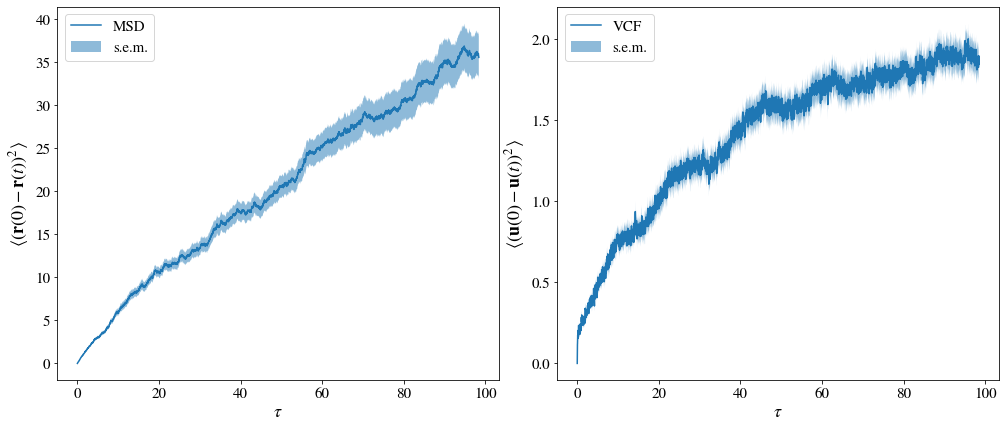

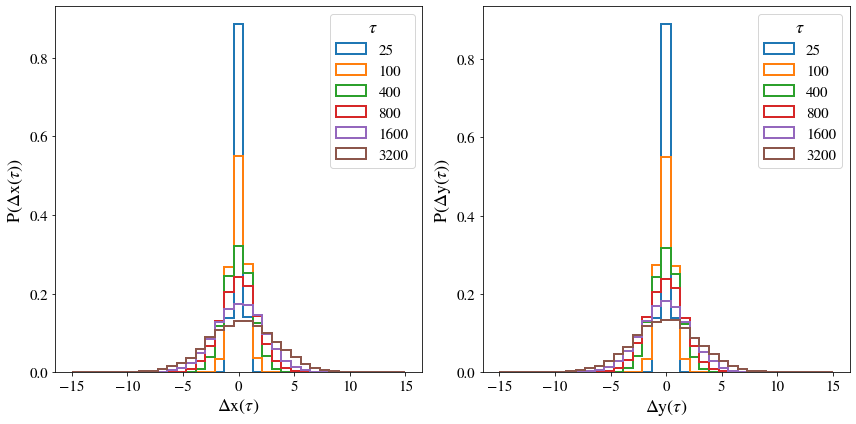

In [320]:
fname = Path("ic_nodr_v020_filament_mt.msd.analysis")
msd, vcf = run_msd_analysis(fname, late_time_percentage=0.1,
                            save_plots=True, show_plots=True, 
                            dist_lag_times=lag_times,
                            dist_xlims = (-15, 15))

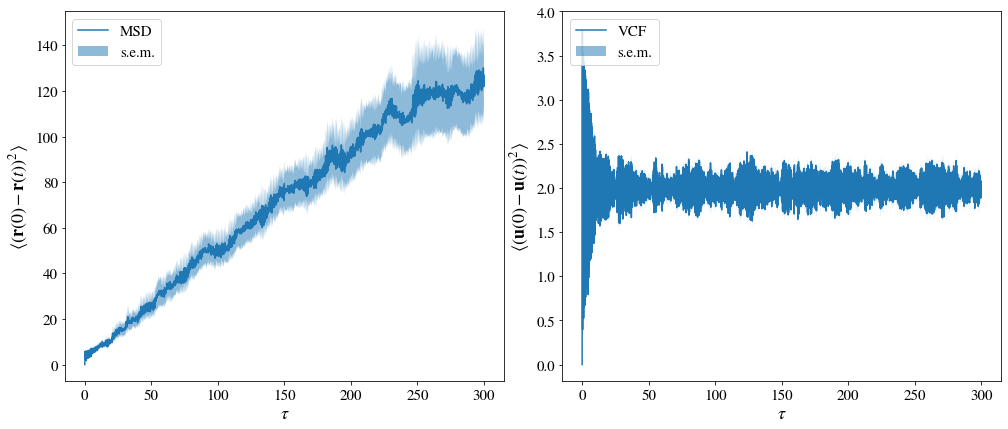

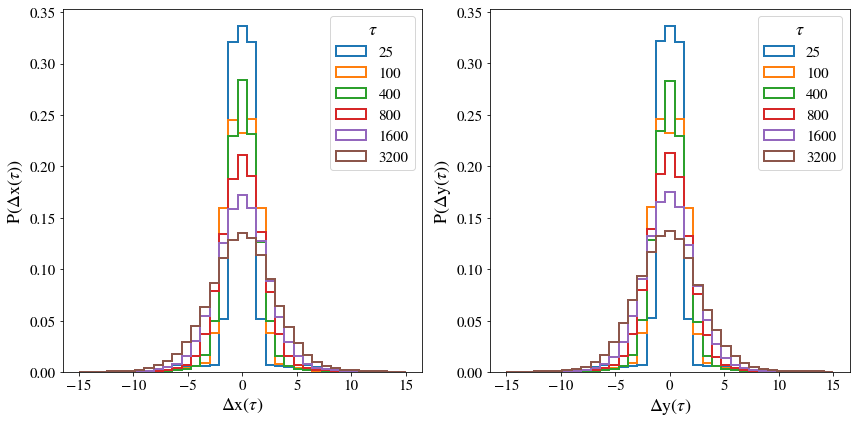

In [321]:
fname = Path("ic_v020_filament_mt.msd.analysis")
msd, vcf = run_msd_analysis(fname, late_time_percentage=0.4,
                            save_plots=True, show_plots=True,
                            dist_lag_times=lag_times,
                            dist_xlims=(-15, 15))

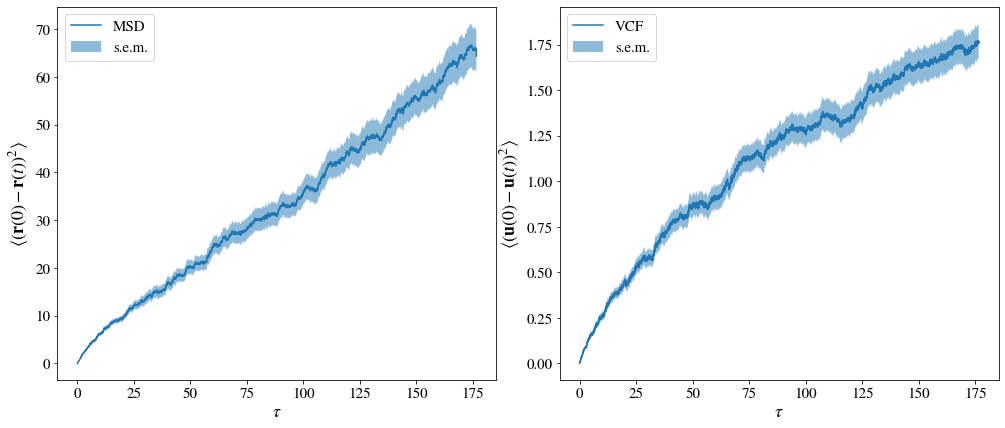

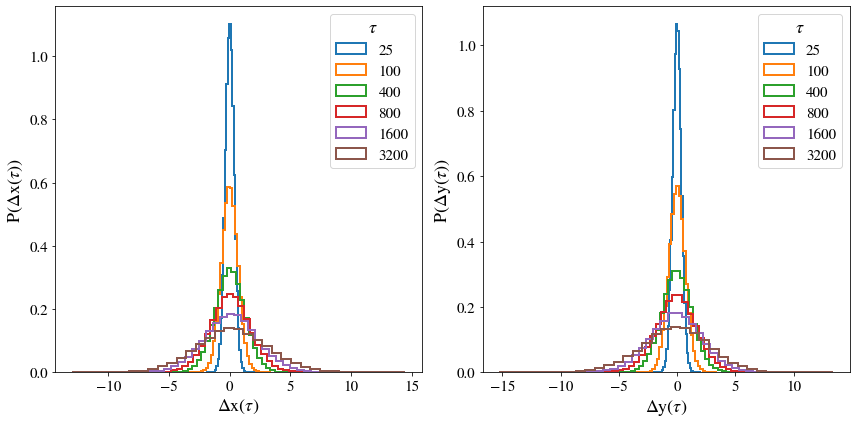

In [322]:
fname = Path("ic_nodr_v037_filament_mt.msd.analysis")
msd, vcf = run_msd_analysis(fname, late_time_percentage=0.2,
                            save_plots=True, show_plots=True,
                            dist_lag_times=lag_times,
                            dist_xlims=None)

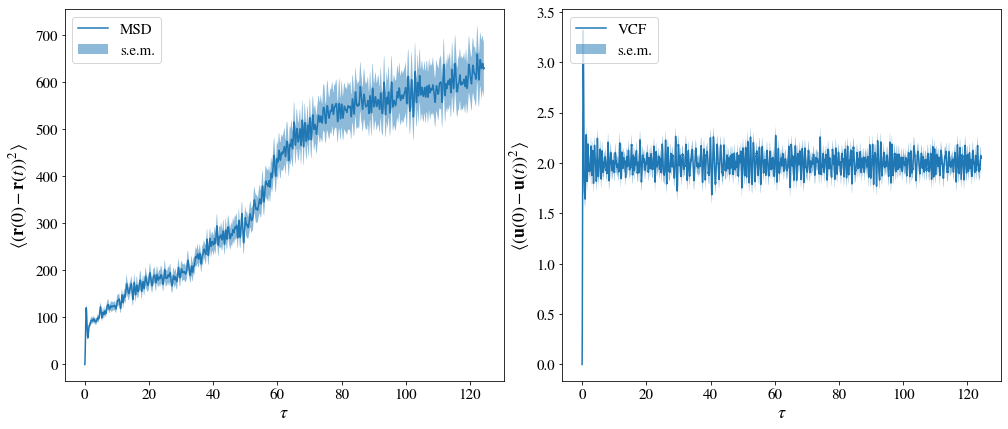

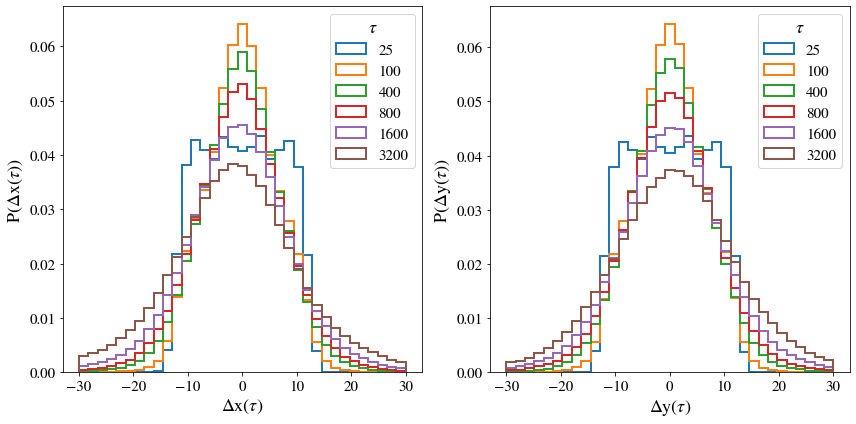

In [323]:
fname = Path("ic_v037_filament_mt.msd.analysis")
msd, vcf = run_msd_analysis(fname, late_time_percentage=0.4,
                            save_plots=True, show_plots=True,
                            dist_lag_times=lag_times,
                            dist_xlims=(-30, 30))

In [299]:
#params, posits = get_params_posits(Path("ic_nodr_v037_filament_mt.msd.analysis"))

In [300]:
params, posits = get_params_posits(Path("ic_v037_filament_mt.msd.analysis"))

In [301]:
posits

filament   fil0000                                     fil0001              \
coord            x        y  z        ux        uy uz        x        y  z   
time                                                                         
0.0000    -3.01855  47.8499  0 -0.999842 -0.017757  0 -40.7343  32.2724  0   
0.0125    -3.01855  47.8499  0 -0.999842 -0.017757  0 -40.7343  32.2724  0   
0.0250    -2.90783  47.8818  0 -0.998045 -0.062507  0 -40.8539  32.4004  0   
0.0375    -2.89607  47.8260  0 -0.999207 -0.039807  0 -40.9192  32.5324  0   
0.0500    -2.90494  47.6702  0 -0.999438  0.033510  0 -40.9529  32.7578  0   
...            ...      ... ..       ...       ... ..      ...      ... ..   
207.1000 -12.56620  71.5817  0  0.142289  0.989825  0 -13.1662  28.1441  0   
207.1130 -12.83530  71.5399  0  0.244780  0.969579  0 -13.2746  27.7620  0   
207.1250 -13.02240  71.7379  0  0.368074  0.929797  0 -13.3909  27.2907  0   
207.1380 -13.35110  71.8831  0  0.489806  0.871831  0 -13.4431  26.8627  0   
207.1500 -13.64610  72.0629  0  0.520534  0.853841  0 -13.3681  26.4811  0   

filament            ... fil0230                         fil0231              \
coord           ux  ...       z        ux        uy uz        x        y  z   
time                ...                                                       
0.0000    0.999999  ...       0 -0.996724 -0.080882  0 -5.64418 -22.5855  0   
0.0125    0.999999  ...       0 -0.996724 -0.080882  0 -5.64418 -22.5855  0   
0.0250    0.997985  ...       0 -0.995864 -0.090856  0 -5.46410 -22.4966  0   
0.0375    0.995817  ...       0 -0.993472 -0.114076  0 -5.42801 -22.5323  0   
0.0500    0.995007  ...       0 -0.990933 -0.134359  0 -5.40968 -22.5799  0   
...            ...  ...     ...       ...       ... ..      ...      ... ..   
207.1000  0.909983  ...       0  0.444261  0.895897  0 -7.43674 -19.4667  0   
207.1130  0.945131  ...       0  0.538967  0.842327  0 -6.92556 -19.6179  0   
207.1250  0.969322  ...       0  0.664632  0.747171  0 -6.45895 -19.9036  0   
207.1380  0.982449  ...       0  0.698131  0.715970  0 -5.84759 -20.1221  0   
207.1500  0.999037  ...       0  0.790125  0.612946  0 -5.46991 -20.3818  0   

filament                         
coord           ux        uy uz  
time                             
0.0000   -0.998124 -0.061231  0  
0.0125   -0.998124 -0.061231  0  
0.0250   -0.999990  0.004400  0  
0.0375   -0.999631  0.027160  0  
0.0500   -0.993258  0.115924  0  
...            ...       ... ..  
207.1000 -0.561885 -0.827215  0  
207.1130 -0.604380 -0.796696  0  
207.1250 -0.630834 -0.775918  0  
207.1380 -0.652201 -0.758046  0  
207.1500 -0.726466 -0.687202  0  

[16573 rows x 1392 columns]

In [302]:
posits = posits.dropna()

In [304]:
posits = posits.iloc[posits.shape[0]//4:]

In [305]:
posits_only = posits.stack('filament').iloc[:, 3:5].unstack('filament').reorder_levels(
    ['filament', 'coord'], axis=1).sort_index(axis=1)

In [306]:
def get_lag_diff(posits, lag_time):
    return posits.diff(periods=lag_time).dropna().iloc[1:].stack('filament')

In [307]:
lag_times = np.exp(np.linspace(0, 9, 40))
lag_times[0] = 0
lag_times = np.unique([int(t) for t in lag_times])
hists = np.array([np.histogram2d(diff.x, diff.y, bins=np.linspace(-20, 20, 100), density=True)[0]
                  for diff in
                  [get_lag_diff(posits_only, int(T)) for T in lag_times]])

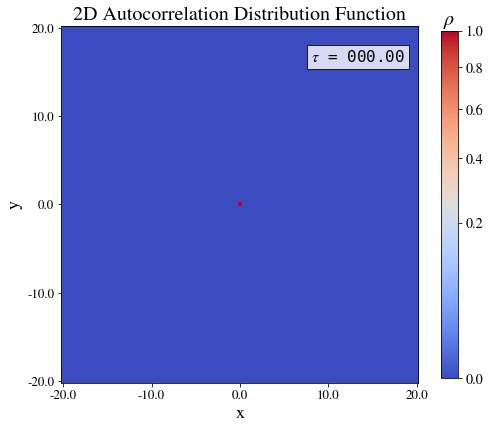

In [314]:
font = {'family': 'DejaVu Sans Mono',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
cax = ax.imshow(hists[0], cmap=plt.cm.coolwarm, vmin=0, vmax=1, norm=PowerNorm(0.5), animated=True, origin='lower')
txt = ax.text(0.7, 0.9, r"$\tau$ = {:06.02f}".format(0), fontdict=font,transform=ax.transAxes, 
              bbox=dict(facecolor='white', alpha=0.8))
cbar = fig.colorbar(cax, shrink=0.8, )
ax.tick_params(labelsize=13)
ax.set_xticks(np.linspace(0, 98, 5))
ax.set_xticklabels([str(i) for i in np.linspace(-20, 20, 5)])
ax.set_yticks(np.linspace(0, 98, 5))
ax.set_yticklabels([str(i) for i in np.linspace(-20, 20, 5)])
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.set_title('2D Autocorrelation Distribution Function', fontsize=20)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title(r'$\rho$', fontsize=20)
times = posits.index - posits.index[0]
def animate(i):
    cax.set_array(hists[i]);
    txt.set_text(r"$\tau$ = {:06.02f}".format(times[int(lag_times[i])]))
ani = animation.FuncAnimation(
    fig, animate, interval=100, frames=range(len(hists)))
ani.save("ic_v037_vh_self.mp4")

In [315]:
HTML(ani.to_html5_video())

In [311]:
posits_by_time = posits_only.stack('filament').unstack('time').reorder_levels(
    ['time', 'coord'], axis=1).sort_index(axis=1)

In [312]:
x0 = pdist(posits_by_time.iloc[:, :2], euclidean_pbc_x)
y0 = pdist(posits_by_time.iloc[:, :2], euclidean_pbc_y)
hist = np.histogram2d(x0[abs(x0)>0], y0[(abs(y0)>0)], bins=np.linspace(-15, 15, 100))[0]
for i in range(10, 10000, 100):
    print(i)
    x0 = pdist(posits_by_time.iloc[:, i:i+2], euclidean_pbc_x)
    y0 = pdist(posits_by_time.iloc[:, i:i+2], euclidean_pbc_y)

    hist += np.histogram2d(x0[abs(x0)>0], y0[(abs(x0)>0)], bins=np.linspace(-15, 15, 100))[0]
hist /= len(list(range(10, 10000, 100)))+1

10
110
210
310
410
510
610
710
810
910
1010
1110
1210
1310
1410
1510
1610
1710
1810
1910
2010
2110
2210
2310
2410
2510
2610
2710
2810
2910
3010
3110
3210
3310
3410
3510
3610
3710
3810
3910
4010
4110
4210
4310
4410
4510
4610
4710
4810
4910
5010
5110
5210
5310
5410
5510
5610
5710
5810
5910
6010
6110
6210
6310
6410
6510
6610
6710
6810
6910
7010
7110
7210
7310
7410
7510
7610
7710
7810
7910
8010
8110
8210
8310
8410
8510
8610
8710
8810
8910
9010
9110
9210
9310
9410
9510
9610
9710
9810
9910


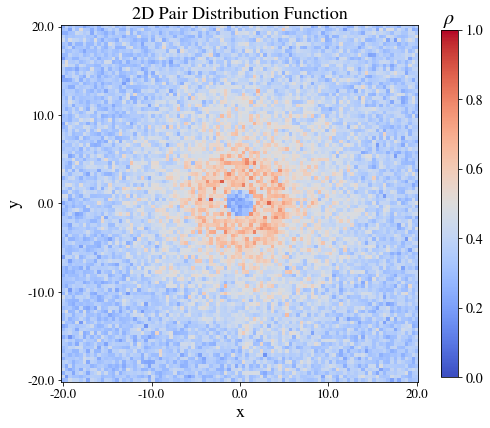

In [313]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
cax = ax.imshow(hist, cmap=plt.cm.coolwarm, vmin=0, vmax=1, norm=PowerNorm(1), animated=True, origin='lower')
cbar = fig.colorbar(cax, shrink=0.8, )
ax.tick_params(labelsize=13)
ax.set_xticks(np.linspace(0, 98, 5))
ax.set_xticklabels([str(i) for i in np.linspace(-20, 20, 5)])
ax.set_yticks(np.linspace(0, 98, 5))
ax.set_yticklabels([str(i) for i in np.linspace(-20, 20, 5)])
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title(r'$\rho$', fontsize=20)
ax.set_title('2D Pair Distribution Function', fontsize=18)
fig.savefig('ic_v037_pdf.png', dpi=300)
plt.show()

In [134]:
x0[abs(x0)>0].shape

(26796,)

In [136]:
y0[abs(y0)>0].shape

(26796,)

In [117]:
xperiodic = 50
def euclidean_pbc_x(u, v):
    x = u - v
    x[x<0] = (x[x<0] / xperiodic - x[x<0] // xperiodic - 1) * xperiodic
    x[x >= 0] = (x[x >= 0] / xperiodic - x[x >= 0] // xperiodic) * xperiodic
    return x[0]
def euclidean_pbc_y(u, v):
    x = u - v
    x[x<0] = (x[x<0] / xperiodic - x[x<0] // xperiodic - 1) * xperiodic
    x[x >= 0] = (x[x >= 0] / xperiodic - x[x >= 0] // xperiodic) * xperiodic
    return x[1]

In [116]:
params

,nsteps,nspec,delta,n_filaments,length,diameter,bond_length,persistence_length,driving,curvature
0,40000000,1000,0.000025,232,10,1,2,1000,0,0.2


In [101]:
x0[x0>0].shape

(13645,)

In [103]:
x0.shape

(26796,)

In [105]:
squareform(x0).diagonal().shape

(232,)

In [106]:
x0

array([ 37.71575, -31.46495,  34.54285, ...,  37.129  ,  54.06978,
        16.94078])